<a href="https://colab.research.google.com/github/DataEngViniciusAtaide/postgresql/blob/main/postgresql_streaming_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Criando ambiente para aplicação da técnica de streaming replication no postgresql.**


Para simular o ambiente eu virtualizei duas máquina ubuntu server 24.04. primary_db e replica_db. Após a instalação foram feitas as seguintes modificações nos dois servidores.


In [ ]:
# sudo apt update
# sudo apt upgrade
# sudo apt install postgresql

Após atualizar e instalar o postgresql, eu  adicionei ao PATH

In [ ]:
# nano ~/.bashrc
# export PATH=/usr/lib/postgresql/16/bin:$PATH
# source ~/.bashrc

Após isso eu criei um novo cluster em /tmp/primary_db, esse cluster será o principal para a experiência:

In [ ]:
# initdb -D /tmp/primary_db

Em seguida eu fiz algumas modificações no postgresql.conf:

In [ ]:
# nano /tmp/primary_db/postgresql.conf

In [ ]:
# listen_addresses = '*'
# port = 5433
# wal_level = replica
# max_wal_senders = 3
# wal_keep_size = 16MB
# hot_standby = on


No arquivo pg_hba.conf a seguinte llinha foi adicionada:

In [ ]:
# nano /tmp/primary_db/pg_hba.conf

In [ ]:
# host    replication     repuser         10.113.220.67/32        trust

Após isso eu dei permissão para o usuario primary do servidor primary_db como informado no código aseguir, mas acho que bastava mudar para o usuario postgres para startar o serviço.

In [ ]:
# sudo chown -R primary:primary /var/run/postgresql

Em seguida startei o cluster

In [ ]:
# pg_ctl -D /tmp/primary_db start

Agora vamos criar um usuario no cluster criado para fazer a replicação através dele:

In [1]:
# psql --port=5433 postgres
# create user repuser replication;

Agora vamos reiniciar o serviço.

In [ ]:
# pg_ctl -D /tmp/primary_db restart

Tive que adicionar um slot manualmente no servidor primario:

In [ ]:
# SELECT * FROM pg_create_physical_replication_slot('replica');


Após isso reiniciei novamente o serviço do primary:

In [ ]:
# pg_ctl -D /tmp/primary_db restart

Partindo do ponto que o servidor réplica esteja atualizado com o postgresql instalado e com o PATH configurado, executei o seguinte comando nele para funcionar como réplica:

In [ ]:
# pg_basebackup -h 10.113.220.60 -U repuser -D /tmp/replicadb/ -R -P --slot=replica --wal-method=stream --port=5433

Agora podemos fazer alguns teste. No primary_db execute:

In [ ]:
# psql --port=5433 postgres
# select * from pg_stat_replication;

Deve aparecer algo como isso:

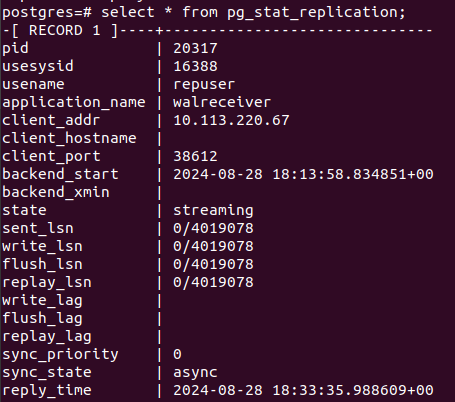

## **No Servidor Réplica**

Após isso startei o cluste no servidor réplica:

In [ ]:
# pg_ctl -D /tmp/replicadb start

Para poder acessar o PSQL no servidor réplica no cluster que está sendo replicado em /tmp/replicadb eu fui no servidor primario e criei um usuario no postgres pra ser comum de acesso nos dois servidores:

O usuário foi criado no servidor primario, como a replicação está funcionando, ele é replicado no servidor réplica.

In [ ]:
# CREATE ROLE replica WITH LOGIN PASSWORD '123456';
# GRANT ALL PRIVILEGES ON tblteste1 TO replica;

OBS.: O usuário que eu criie "replica" é o mesmo usuário do SO do servidor replica, possui o mesmo nome, então se você tiver algum problema com relação a permissão, tenta criar o usuário do banco com o mesmo nome do usuário do SO do servidor réplica. Pode ser que não haja relação, vou fazer um teste posteriormente.

Eu liberei all privileges, mas pode ser liberado como necessário.

# **fiz alguns teste e a replicação está funcionando perfeitamente.**